In [ ]:
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord as SkyCoord

In [49]:
def flux_density_cut(data,column_index,min,max):
    Index = 0
    Index_list = []
    for row in np.array(data):
        S = row[column_index]
        if S<min or S>max:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    data_array = np.array(data)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)
    return new_data

# Elimando fonte que estejam com B em [-b,b]
def galactic_cut(data,RA_column_index,Dec_column_index,Lim_inf,Lim_sup):

    data_array = np.array(data)

    ra_column_array = data_array[:,RA_column_index]
    dec_column_array = data_array[:,Dec_column_index]

    c = SkyCoord(ra_column_array,dec_column_array, frame='icrs', unit='deg')

    b_array = np.array(c.galactic.b)

    Index = 0
    Index_list = []
    for b in b_array:
        if b > Lim_inf  and b < Lim_sup:
            Index_list.append(Index)
        Index+=1

    index_to_delete = np.array(Index_list)
    new_data_array = np.delete(data_array,index_to_delete,axis=0)
    new_data = pd.DataFrame(new_data_array,columns=data.columns.values)

    return new_data

# Essa funcao transforma coordenadas icrs em coordenadas cartesianas
@numba.njit
def icrs_to_vetor_position(ra, dec):

    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)

    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)

    # Construindo o array manualmente
    n = ra.size  # ou len(ra)
    coord_ca_cartesian_array = np.zeros((n, 3), dtype=np.float64)
    coord_ca_cartesian_array[:, 0] = x
    coord_ca_cartesian_array[:, 1] = y
    coord_ca_cartesian_array[:, 2] = z

    return coord_ca_cartesian_array

def estimador(coord_ca_cartesian_array, central_pixels_positions):

  delta_list = np.empty(len(central_pixels_positions), dtype=np.float64)
  delta_coord = np.empty((len(central_pixels_positions), 3), dtype=np.float64)

  for i in range(len(central_pixels_positions)):

    a, b, c = central_pixels_positions[i]
    dot_products = coord_ca_cartesian_array @ np.array([a, b, c])

    up = coord_ca_cartesian_array[dot_products > 0]
    down = coord_ca_cartesian_array[dot_products < 0]

    # fração do céu disponivel
    pix_indices = hp.vec2pix(nside, np.array(up)[:,0], np.array(up)[:,1], np.array(up)[:,2])
    # Contando o número de fontes em cada pixel
    density_map = np.bincount(pix_indices, minlength=npix)
    # Contar quantos pixels não estão vazios
    visible_pixels = np.sum(density_map != 0)
    # fração do céu disponivel
    f_sky_up_i = visible_pixels/npix

    down = np.array(down)
    pix_indices = hp.vec2pix(nside, np.array(down)[:,0], np.array(down)[:,1], np.array(down)[:,2])
    # Contando o número de fontes em cada pixel
    density_map = np.bincount(pix_indices, minlength=npix)
    # Contar quantos pixels não estão vazios
    visible_pixels = np.sum(density_map != 0)
    # fração do céu disponivel
    f_sky_down_i = visible_pixels/npix

    sigma_up = len(up) / (4*np.pi* f_sky_up_i )
    sigma_down = len(down) / (4*np.pi* f_sky_down_i  )
    delta = (sigma_up - sigma_down) / sigma

    delta_list[i] = delta

  index = np.where(0.95 * delta_list.max() < delta_list)[0]
  x, y, z = central_pixels_positions[index][:,0], central_pixels_positions[index][:,1], central_pixels_positions[index][:,2]

  c = SkyCoord(x, y, z, representation_type='cartesian')

  l, l_erro = c.galactic.l.value.max(), c.galactic.l.value.max()-c.galactic.l.value.min()
  b, b_erro = c.galactic.b.value.max(), c.galactic.b.value.max()-c.galactic.b.value.min()

  delta_max, delta_max_erro = delta_list[index].max(),delta_list[index].max()-delta_list[index].min()

  return delta_max, delta_max_erro,l,l_erro,b,b_erro

def graf_dipolo(corte_b, delta_max, delta_max_erro, l, l_erro, b, b_erro):
    # # Plotagem do Gráfico

    C = SkyCoord(l, b, frame='galactic',unit='deg')

    co_cmb = SkyCoord(264, 48 , frame='galactic',unit='deg')

    l_cmb = -co_cmb.l.wrap_at(180 * u.deg).radian
    b_cmb = co_cmb.b.radian

    l1 = -C.l.wrap_at(180 * u.deg).radian
    b1 = C.b.radian

    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(15,4.2))
    ax = fig.add_subplot(111, projection='mollweide')
    #ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°°', '90°', '120°', '150°'])
    ax.set_xticklabels(['150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°'])

    #plt.subplot(111, projection="mollweide")
    plt.title(r'Dipolo {}, N={}, $N_{{side}}={}$'.format(name,len(data),nside),y=1.05)

    plt.grid(True)

    plt.plot(l_cmb,b_cmb,'*', markersize=10, color='black',label=f'CMB dipole ({co_cmb.l.value}°,{co_cmb.b.value}°)')
    #plt.plot(l0, b0,'*', markersize=10, color='blue',label=r'$|b|< 10°$ , $(l,b)=({:.2f}°,{:.2f}°)$'.format(C0.l.value, C0.b.value))
    plt.plot(l1, b1,'*', markersize=10, color='red',label=r'$|b|< {}°$ , $A={:.3f}±{:.3f}$ , $(l,b)=({:.2f}°±{:.2f}°,{:.2f}°±{:.2f}°)$'.format(corte_b, delta_max, delta_max_erro, l, l_erro, b, b_erro))

    plt.subplots_adjust(top=1,bottom=0)
    plt.legend(loc=4)
    plt.xlabel('Galactic longitude, $l$ [deg]')
    plt.ylabel('Galactic latitude, $b$ [deg]')

    return plt.show()

In [57]:
# Importando o catálogo NVSS em CSV
name = r'Densidade de Fontes NVSS, 20mJy < S < 1000mJy'
nvss = pd.read_csv('NVSS_Catalog.csv')

# Eliminando fontes com S entre 20 mJy e 1000 mJy
nvss_flux_20_1000 = flux_density_cut(nvss,4,20,1000)

# Eliminando o plano galáctico
corte_b = 20
nvss_flux_20_1000_cut_galac = galactic_cut(nvss_flux_20_1000,0,1,-corte_b,corte_b)

data = nvss_flux_20_1000_cut_galac

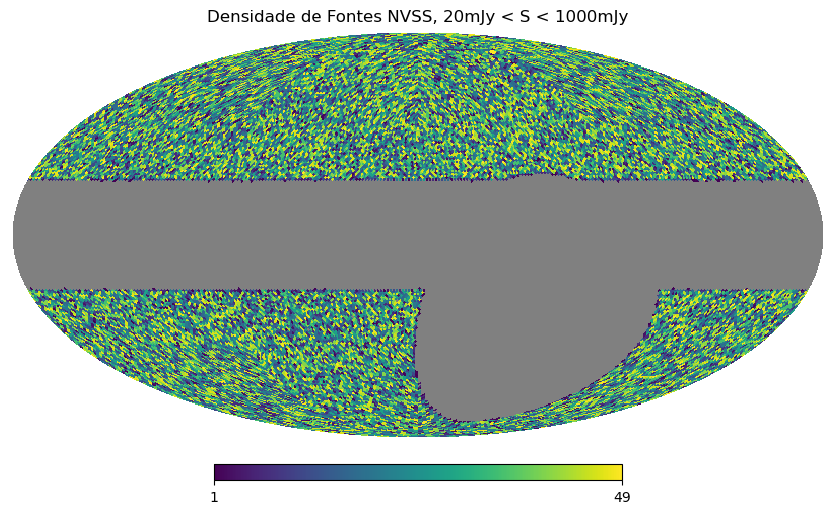

In [58]:
# Definindo o NSIDE e calculando o número de pixels
nside = 64
npix = hp.nside2npix(nside)

#       1 - Coordenadas cartesianas das fontes e dos pixels
#-------------------------------------------------------------------------------

# Obtendo os angulos dos pixels em coordenadas esféricas padrão em radianos
thetas_pixels, phis_pixels = hp.pix2ang(nside, np.arange(npix))

# obtendo as coordenadas centrais cartesianas de cada pixel
central_pixels_positions = hp.ang2vec(thetas_pixels,phis_pixels)


# obtendo as coordenadas cartesianas de cada fontes
ra, dec = np.array(data['RA']), np.array(data['DEC'])

# Converter RA e Dec para SkyCoord
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Converter para coordenadas Equatorias p/ galácticas (l, b)
gal_coords = coords.galactic
l = gal_coords.l.deg
b = gal_coords.b.deg

coord_ca_cartesian_array = icrs_to_vetor_position(ra,dec)
#-------------------------------------------------------------------------------


#                     2 - Mapa de densidade
#-------------------------------------------------------------------------------

# convertendo ra e dec p/ angulos em esfericos (theta, phi)
phis_fontes = np.radians(l)
thetas_fontes = np.radians(90.0 - b)

# Convertendo (theta, phi) das fontes para índices de pixel Healpy
# Também podemos pensar: Qual pixel contém a coordenada (theta, phi) ?
pix_indices = hp.ang2pix(nside, thetas_fontes, phis_fontes)

# Contando o número de fontes em cada pixel
density_map = np.bincount(pix_indices, minlength=npix)
#-------------------------------------------------------------------------------

# Convertendo density_map para float64 para suportar hp.UNSEEN
density_map = density_map.astype(np.float64)

# Criando a máscara para os pixels onde não há fontes (valor zero)
mask = density_map > 0

# Aplicando a máscara ao mapa para criar um mapa mascarado
masked_map = np.copy(density_map)
masked_map[~mask] = hp.UNSEEN


# # Visualizar o mapa de densidade
hp.mollview(masked_map, title=name,
            norm='hist')
plt.show()

In [59]:
# Contar quantos pixels não estão vazios
visible_pixels = np.sum(density_map != 0)

# fração do céu observada
f_sky = visible_pixels/npix

sigma = len(coord_ca_cartesian_array) / (4*np.pi*f_sky)

In [60]:
delta_max, delta_max_erro, l, l_erro, b, b_erro = estimador(coord_ca_cartesian_array, central_pixels_positions)

print(rf'A_{{obs}} = {delta_max:.3f} ± {delta_max_erro:.3f}')
print(f'(l,b) = ({l:.2f} ± {l_erro:.2f}, {b:.2f} ± {b_erro:.2f})')

A_{obs} = 0.033 ± 0.002
(l,b) = (260.97 ± 13.88, 32.73 ± 6.30)


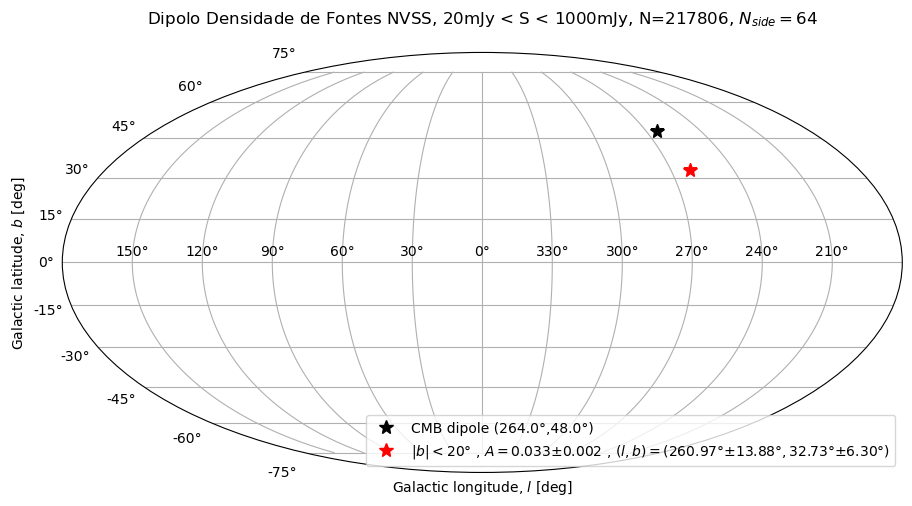

In [61]:
graf_dipolo(corte_b, delta_max, delta_max_erro, l, l_erro, b, b_erro)